# Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_auc_score
from keras import initializers
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Bidirectional
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

np.set_printoptions(precision=3, suppress=True)

seed = 16
np.random.seed(seed)

C:\Users\AHuang\Anaconda3\envs\keras\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\AHuang\Anaconda3\envs\keras\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\AHuang\Anaconda3\envs\keras\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)
Using TensorFlow backend.


C:\Users\AHuang\Anaconda3\envs\keras\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Clean and cheat samples, total')

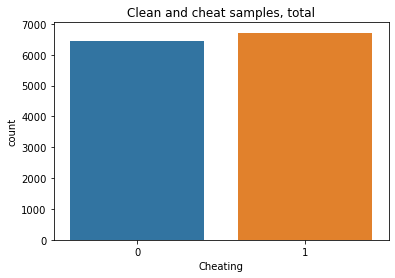

In [2]:
df = pd.read_csv('train.csv', header=None, delimiter=',',encoding='latin-1')

sb.countplot(df[0])
plt.xlabel('Cheating')
plt.title('Clean and cheat samples, total')

In [3]:
num_samples = 48
num_features = 0

def extract_features(df):
    global num_samples # why tho
    global num_features
    data = df.to_numpy()
    
    Y = data[:, 0]
    X = data[:, 1:]
    
    # Only us some features
    features = [0, 1, 2, 3, 4, 5, 6]
    num_features = len(features)
    idxs = []
    
    for i in range(X.shape[1]):
        if (i >= 7 * num_samples):
            continue
        if (i % 7) in features:
            idxs.append(i)
            
    num_samples = len(idxs) // num_features
    X = X[:, idxs]
    X = X.reshape(-1, num_samples, num_features)
    
    return X, Y
    

def split(X, Y):
    X_train, X_val, Y_train, Y_val = [], [], [], []
    
    # Split training at test set, in chunks to prevent information leak
    chunk_size = 100
    val_fraction = 0.2
    chunks = [[*range(chunk_size * i, chunk_size * (i+1))] for i in range(Y.shape[0]//chunk_size)]
    chunks.append([*range(chunk_size * (Y.shape[0]//chunk_size - 1), Y.shape[0] -1)])
    np.random.shuffle(chunks)
    
    for i, chunk in enumerate(chunks):
        if i < len(chunks) * 0.2:
            X_val.extend(X[chunk])
            Y_val.extend(Y[chunk])
        else:
            X_train.extend(X[chunk])
            Y_train.extend(Y[chunk])
            
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    X_val = np.array(X_val)
    Y_val = np.array(Y_val)
    
    return X_train, Y_train, X_val, Y_val

In [10]:
X, Y = extract_features(df)
X_train, Y_train, X_val, Y_val = split(X, Y)

C:\Users\AHuang\Anaconda3\envs\keras\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Clean and cheat samples, validation')

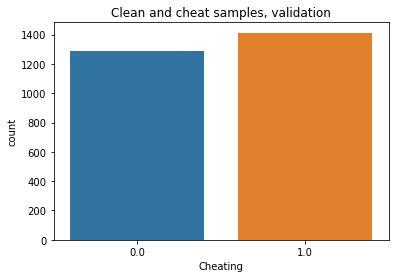

In [11]:
sb.countplot(Y_val)
plt.xlabel('Cheating')
plt.title('Clean and cheat samples, validation')

In [6]:
#values = np.moveaxis(X_train, 2, 0)
#values = values.reshape(values.shape[0], -1)
#means = np.mean(values, axis=1)
#stds = np.std(values, axis=1)
#print(means)
#print(stds)
#means = np.array([0, 0, 0, 0, 0, 0, 0]) # Vectors should be 0 mean
#stds = np.array([1, 1, 1, 1, 1, 1, 1])
#
#X_train_norm = np.moveaxis(X_train, 2, 0)
#X_train_norm = X_train_norm.reshape(X_train.shape[2], -1)
#means_repeat = np.repeat(means[:, np.newaxis], X_train_norm.shape[1], axis=1)
#stds_repeat = np.repeat(stds[:, np.newaxis], X_train_norm.shape[1], axis=1)
#X_train_norm -= means_repeat
#X_train_norm /= stds_repeat
#X_train_norm = X_train_norm.reshape(X_train.shape[2], X_train.shape[0], -1)
#X_train_norm = np.moveaxis(X_train_norm, 0, 2)
#X_train = X_train_norm
#
#X_val_norm = np.moveaxis(X_val, 2, 0)
#X_val_norm = X_val_norm.reshape(X_val.shape[2], -1)
#means_repeat = np.repeat(means[:, np.newaxis], X_val_norm.shape[1], axis=1)
#stds_repeat = np.repeat(stds[:, np.newaxis], X_val_norm.shape[1], axis=1)
#X_val_norm -= means_repeat
#X_val_norm /= stds_repeat
#X_val_norm = X_val_norm.reshape(X_val.shape[2], X_val.shape[0], -1)
#X_val_norm = np.moveaxis(X_val_norm, 0, 2)
#X_val = X_val_norm

In [23]:
def RNN():
    inputs = Input(name='inputs',shape=[num_samples, num_features])
   
    layer = LSTM(
        512,
        return_sequences=False,
        kernel_regularizer=regularizers.l2(1e-4)
    )(inputs)
    #layer = Bidirectional(LSTM(128, return_sequences=False))(inputs)
    #layer = Bidirectional(LSTM(128))(layer)
    
    layer = Dense(512, name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1, name='out')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [24]:
model = RNN()
model.summary()
opt = RMSprop(learning_rate=6e-4)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 48, 7)]           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 512)               1064960   
_________________________________________________________________
FC1 (Dense)                  (None, 512)               262656    
_________________________________________________________________
activation_10 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
out (Dense)                  (None, 1)                 513       
_________________________________________________________________
activation_11 (Activation)   (None, 1)               

In [25]:
model.fit(
    X_train,
    Y_train,
    batch_size=1800,
    epochs=100,
    validation_data = (X_val, Y_val))
    #callbacks=[EarlyStopping(monitor='val_accuracy', patience=50)])

Epoch 1/100
6/6 [==============================] - 2s 255ms/step - loss: 0.9070 - accuracy: 0.5178 - val_loss: 0.7938 - val_accuracy: 0.5600
Epoch 2/100
6/6 [==============================] - 1s 186ms/step - loss: 0.7880 - accuracy: 0.5479 - val_loss: 0.7921 - val_accuracy: 0.4789
Epoch 3/100
6/6 [==============================] - 1s 181ms/step - loss: 0.7701 - accuracy: 0.5525 - val_loss: 0.7560 - val_accuracy: 0.5615
Epoch 4/100
6/6 [==============================] - 1s 182ms/step - loss: 0.7616 - accuracy: 0.5422 - val_loss: 0.7395 - val_accuracy: 0.5874
Epoch 5/100
6/6 [==============================] - 1s 173ms/step - loss: 0.7369 - accuracy: 0.5720 - val_loss: 0.7303 - val_accuracy: 0.5789
Epoch 6/100
6/6 [==============================] - 1s 172ms/step - loss: 0.7361 - accuracy: 0.5529 - val_loss: 0.7254 - val_accuracy: 0.5737
Epoch 7/100
6/6 [==============================] - 1s 174ms/step - loss: 0.7317 - accuracy: 0.5537 - val_loss: 0.7205 - val_accuracy: 0.5578
Epoch 8/100
6

Epoch 59/100
6/6 [==============================] - 1s 178ms/step - loss: 0.5018 - accuracy: 0.7609 - val_loss: 0.7280 - val_accuracy: 0.6370
Epoch 60/100
6/6 [==============================] - 1s 181ms/step - loss: 0.4535 - accuracy: 0.7947 - val_loss: 0.7871 - val_accuracy: 0.6359
Epoch 61/100
6/6 [==============================] - 1s 187ms/step - loss: 0.4665 - accuracy: 0.7786 - val_loss: 0.8078 - val_accuracy: 0.6374
Epoch 62/100
6/6 [==============================] - 1s 196ms/step - loss: 0.4478 - accuracy: 0.7935 - val_loss: 0.7999 - val_accuracy: 0.6437
Epoch 63/100
6/6 [==============================] - 1s 174ms/step - loss: 0.4604 - accuracy: 0.7874 - val_loss: 0.7704 - val_accuracy: 0.6548
Epoch 64/100
6/6 [==============================] - 1s 177ms/step - loss: 0.4268 - accuracy: 0.8094 - val_loss: 0.8035 - val_accuracy: 0.6481
Epoch 65/100
6/6 [==============================] - 1s 182ms/step - loss: 0.4319 - accuracy: 0.8055 - val_loss: 0.8056 - val_accuracy: 0.6544
Epoch 

ROC AUC: 0.641


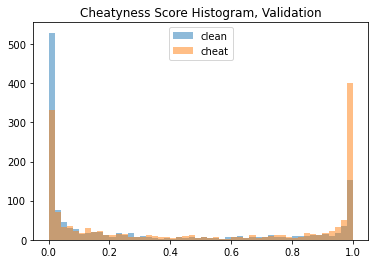

In [26]:
probabilities = model.predict(X_val)

print('ROC AUC: {:.3f}'.format(roc_auc_score(Y_val, probabilities)))

clean_scores = []
cheat_scores = []

for i, p in enumerate(probabilities):
    if (Y_val[i]) == 0:
        clean_scores.append(p.item())
    else:
        cheat_scores.append(p.item())
        
plt.hist(clean_scores, label='clean', bins=50, alpha=0.5)
plt.hist(cheat_scores, label='cheat', bins=50, alpha=0.5)
plt.title("Cheatyness Score Histogram, Validation")
plt.legend(loc = 'upper center')
plt.show()

In [27]:
df_test = pd.read_csv('other.csv', header=None, delimiter=',',encoding='latin-1')
X_test, Y_test = extract_features(df_test)

In [28]:
model = RNN()
model.summary()
opt = RMSprop(learning_rate=6e-4)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model.fit(
    X,
    Y,
    batch_size=1800,
    epochs=100,
    validation_data = (X_test, Y_test))

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 48, 7)]           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 512)               1064960   
_________________________________________________________________
FC1 (Dense)                  (None, 512)               262656    
_________________________________________________________________
activation_12 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
out (Dense)                  (None, 1)                 513       
_________________________________________________________________
activation_13 (Activation)   (None, 1)               

Epoch 48/100
8/8 [==============================] - 1s 179ms/step - loss: 0.4988 - accuracy: 0.7601 - val_loss: 0.8470 - val_accuracy: 0.5487
Epoch 49/100
8/8 [==============================] - 1s 165ms/step - loss: 0.5404 - accuracy: 0.7345 - val_loss: 0.7907 - val_accuracy: 0.6014
Epoch 50/100
8/8 [==============================] - 1s 158ms/step - loss: 0.4900 - accuracy: 0.7673 - val_loss: 0.6951 - val_accuracy: 0.6284
Epoch 51/100
8/8 [==============================] - 1s 159ms/step - loss: 0.4793 - accuracy: 0.7734 - val_loss: 0.7306 - val_accuracy: 0.6170
Epoch 52/100
8/8 [==============================] - 1s 161ms/step - loss: 0.4798 - accuracy: 0.7748 - val_loss: 0.8036 - val_accuracy: 0.5952
Epoch 53/100
8/8 [==============================] - 1s 160ms/step - loss: 0.4498 - accuracy: 0.7971 - val_loss: 0.7561 - val_accuracy: 0.6284
Epoch 54/100
8/8 [==============================] - 1s 160ms/step - loss: 0.4770 - accuracy: 0.7766 - val_loss: 0.8400 - val_accuracy: 0.5880
Epoch 

ROC AUC: 0.593


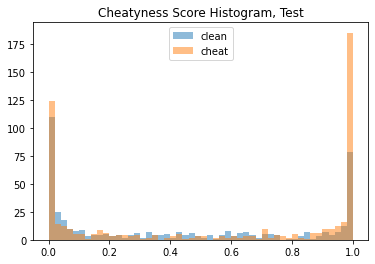

In [29]:
clean_scores = []
cheat_scores = []

probabilities = model.predict(X_test) 

print('ROC AUC: {:.3f}'.format(roc_auc_score(Y_test, probabilities)))

for i, p in enumerate(probabilities):
    if (Y_test[i]) == 0:
        clean_scores.append(p.item())
    else:
        cheat_scores.append(p.item())
        
plt.hist(clean_scores, label='clean', bins=50, alpha=0.5)
plt.hist(cheat_scores, label='cheat', bins=50, alpha=0.5)
plt.title("Cheatyness Score Histogram, Test")
plt.legend(loc='upper center')
plt.show()